---
syncID: e6ccf19a4b454ca594388eeaa88ebe12
title: "Calculate Vegetation Biomass from LiDAR Data in Python"
description: "Learn to calculate the biomass of standing vegetation using a canopy height model data product." 
dateCreated: 2017-06-21 
authors: Tristan Goulden
contributors: 
estimatedTime:
packagesLibraries: numpy, gdal, matplotlib, matplotlib.pyplot, os
topics: lidar,remote-sensing
languagesTool: python
dataProduct: DP1.10098, DP3.30015, 
code1: Python/remote-sensing/lidar/calc_biomass_py.ipynb
tutorialSeries: intro-lidar-py-series
urlTitle: calc-biomass-py
---

<div id="ds-objectives" markdown="1">

In this tutorial, we will calculate the biomass for a section of the SJER site. We 
will be using the Canopy Height Model discrete LiDAR data product as well as NEON
field data on vegetation data. This tutorial will calculate Biomass for individual 
trees in the forest. 

### Objectives
After completing this tutorial, you will be able to:

* Learn how to apply a guassian smoothing fernal for high-frequency spatial filtering
* Apply a watershed segmentation algorithm for delineating tree crowns
* Calculate biomass predictor variables from a CHM
* Setup training data for Biomass predictions
* Apply a Random Forest machine learning approach to calculate biomass


### Install Python Packages

* **numpy**
* **gdal** 
* **matplotlib** 
* **matplotlib.pyplot** 
* **os**


### Download Data

If you have already downloaded the data set for the Data Institute, you have the 
data for this tutorial within the SJER directory. If you would like to just 
download the data for this tutorial use the following link. 

<a href="https://neondata.sharefile.com/d-s58db39240bf49ac8" class="link--button link--arrow">
Download the Biomass Calculation teaching data subset</a>

</div>

In this tutorial, we will calculate the biomass for a section of the SJER site. We 
will be using the Canopy Height Model discrete LiDAR data product as well as NEON
field data on vegetation data. This tutorial will calculate Biomass for individual 
trees in the forest. 

The calculation of biomass consists of four primary steps:

1. Delineating individual tree crowns
2. Calculating predictor variables for all individuals
3. Collecting training data
4. Applying a regression model to estiamte biomass from predictors

In this tutorial we will use a watershed segmentation algorithm for delineating 
tree crowns (step 1) and and a Random Forest (RF) machine learning algorithm for 
relating the predictor variables to biomass (part 4). The predictor variables were 
selected following suggestions by Gleason et al. (2012) and biomass estimates were 
determined from DBH (diamter at breast height) measurements following relationships 
given in Jenkins et al. (2003). 

## Get Started

First, we will import several of the typical libraries. 

In [1]:
import numpy as np
import os
import gdal, osr
import matplotlib.pyplot as plt
import sys
from scipy import ndimage as ndi
%matplotlib inline 

Next, we will add libraries from skilearn which will help with the watershed delination, determination of predictor variables and random forest algorithm

In [2]:
#Import biomass specific libraries
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

## Define functions 

Now we will define a few functions that allow us to more easily work with the NEON data. 

* `plot_band_array`: function to plot NEON spatial data.

In [3]:
#Define plot band array function

def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)


* `array2raster`: function to output geotiff files.

In [4]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    

* `raster2array`: function to conver rasters to an array.

In [5]:
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} # make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,
                                                     metadata['array_cols'],
                                                     metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata

    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

* `crown_geometric_volume_pth`: function to get tree crown volumn. 

In [6]:
def crown_geometric_volume_pth(tree_data,min_tree_height,pth):
    p = np.percentile(tree_data, pth)
    tree_data_pth = [v if v < p else p for v in tree_data]
    crown_geometric_volume_pth = np.sum(tree_data_pth - min_tree_height)
    return crown_geometric_volume_pth, p

* `get_predictors`: function to get the trees from the biomass data. 

In [7]:
def get_predictors(tree,chm_array, labels):
    indexes_of_tree = np.asarray(np.where(labels==tree.label)).T
    tree_crown_heights = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    
    full_crown = np.sum(tree_crown_heights - np.min(tree_crown_heights))
    
    crown50, p50 = crown_geometric_volume_pth(tree_crown_heights,tree.min_intensity,50)
    crown60, p60 = crown_geometric_volume_pth(tree_crown_heights,tree.min_intensity,60)
    crown70, p70 = crown_geometric_volume_pth(tree_crown_heights,tree.min_intensity,70)
    
        
    return [tree.label,
            np.float(tree.area),
            tree.major_axis_length,
            tree.max_intensity,
            tree.min_intensity, 
            p50, p60, p70,
            full_crown, crown50, crown60, crown70]

## Canopy Height Data

With everything set up, we can now start working with our data by define the file path to our CHM file.

In [9]:
chm_file = '/Users/olearyd/Downloads/Files/NEON_D17_SJER_DP3_256000_4106000_CHM.tif'

When we output the results, we will want to include the same file information as the input, so we will gather the file name information. 

In [10]:
#Get info from chm file for outputting results
just_chm_file = os.path.basename(chm_file)
just_chm_file_split = just_chm_file.split(sep="_")

Now we will get the CHM data...

In [11]:
chm_array, chm_array_metadata = raster2array(chm_file)

..., plot it, and save the figure.

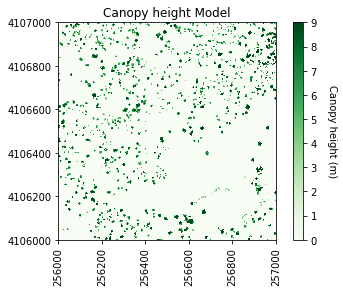

In [12]:
#Plot the original CHM
plt.figure(1)

#Plot the CHM figure
plot_band_array(chm_array,chm_array_metadata['extent'],
                'Canopy height Model',
                'Canopy height (m)',
                'Greens',[0, 9])
plt.savefig(just_chm_file[0:-4]+'_CHM.png',dpi=300,orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)


It looks like SJER primarily has low vegetation with scattered taller trees. 

## Create Filtered CHM

Now we will use a Gaussian smoothing kernal (convolution) across the data set to remove spurious high vegetation points. This will help ensure we are finding the treetops properly before running the watershed segmentation algorithm. 

For different forest types it may be necessary to change the input parameters. Information on the function can be found in the <a href="https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.filters.gaussian_filter.html" target="_blank">SciPy documentation</a>. 

Of most importance are the second and fifth inputs. The second input defines the standard deviation of the Gaussian smoothing kernal. Too large a value will apply too much smoothing, too small and some spurious high points may be left behind. The fifth, the truncate value, controls after how many standard deviations the Gaussian kernal will get cut off (since it theoretically goes to infinity).

In [13]:
#Smooth the CHM using a gaussian filter to remove spurious points
chm_array_smooth = ndi.gaussian_filter(chm_array,2,
                                       mode='constant',cval=0,truncate=2.0)
chm_array_smooth[chm_array==0] = 0 

Now save a copy of filtered CHM. We will later use this in our code, so we'll output it into our data directory. 

In [14]:
#Save the smoothed CHM
array2raster('../Data/chm_filter.tif',
             (chm_array_metadata['ext_dict']['xMin'],chm_array_metadata['ext_dict']['yMax']),
             1,-1,
             np.array(chm_array_smooth,dtype=float),
             32611)

## Determine local maximums

Now we will run an algorithm to determine local maximums within the image. Setting indices to 'False' returns a raster of the maximum points, as opposed to a list of coordinates. The footprint parameter is an area where only a single peak can be found. This should be approximately the size of the smallest tree. Information on more sophisticated methods to define the window can be found in Chen (2006).  

In [15]:
#Calculate local maximum points in the smoothed CHM
local_maxi = peak_local_max(chm_array_smooth,indices=False, footprint=np.ones((5, 5)))

Plot the raster of local maximums. The following figure shows the difference in finding local maximums for a filtered vs. non-filtered CHM.

We will save the graphics (.png) in an outputs folder sister to our working directory and data outputs (.tif) to our data directory. 

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

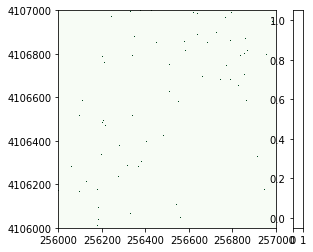

In [16]:
#Plot the local maximums
plt.figure(2)
plot_band_array(local_maxi,chm_array_metadata['extent'],
                'Maximum',
                'Maxi',
                'Greys',
                [0, 1])

plt.savefig('../output/'+just_chm_file[0:-4]+ '_Maximums.png',
            dpi=300,orientation='landscape',
            bbox_inches='tight',pad_inches=0.1)

array2raster('../Data/maximum.tif',
             (chm_array_metadata['ext_dict']['xMin'],chm_array_metadata['ext_dict']['yMax']),
             1,-1,np.array(local_maxi,dtype=np.float32),32611)


If we were to look at the overlap between the tree crowns and the local maxima from each method, it would appear a bit like this raster. 

 <figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/raster-general/raster-classification-filter-vs-nonfilter.jpg">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/raster-general/raster-classification-filter-vs-nonfilter.jpg"></a>
	<figcaption> The difference in finding local maximums for a filtered vs. 
	non-filtered CHM. 
	Source: National Ecological Observatory Network (NEON) 
	</figcaption>
</figure>


Apply labels to all of the local maximum points

In [17]:
#Identify all the maximum points
markers = ndi.label(local_maxi)[0]

Next we will create a mask layer of all of the vegetation points so that the watershed segmentation will only occur on the trees and not extend into the surrounding ground points. Since 0 represent ground points in the CHM, setting the mask to 1 where the CHM is not zero will define the mask

In [18]:
#Create a CHM mask so the segmentation will only occur on the trees
chm_mask = chm_array_smooth
chm_mask[chm_array_smooth != 0] = 1

## Watershed segmentation

As in a river system, a watershed is divided by a ridge that divides areas. Here our watershed are the individual tree canopies and the ridge is the delineation between each one. 

<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/raster-general/raster-classification-watershed-segments.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/raster-general/raster-classification-watershed-segments.png"></a>
	<figcaption> A raster classified based on watershed segmentation. 
	Source: National Ecological Observatory Network (NEON) 
	</figcaption>
</figure>

Next, we will perform the watershed segmentation which produces a raster of labels.

In [19]:
#Perfrom watershed segmentation        
labels = watershed(chm_array_smooth, markers, mask=chm_mask)
labels_for_plot = labels.copy()
labels_for_plot = np.array(labels_for_plot,dtype = np.float32)
labels_for_plot[labels_for_plot==0] = np.nan
max_labels = np.max(labels)


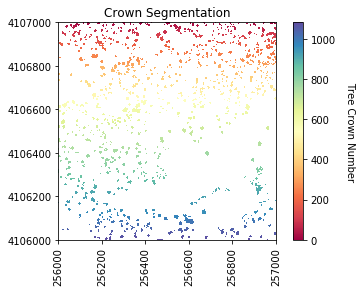

In [21]:
#Plot the segments      
plot_band_array(labels_for_plot,chm_array_metadata['extent'],
                'Crown Segmentation','Tree Crown Number',
                'Spectral',[0, max_labels])

plt.savefig(just_chm_file[0:-4]+'_Segmentation.png',
            dpi=300,orientation='landscape',
            bbox_inches='tight',pad_inches=0.1)

array2raster('labels.tif',
             (chm_array_metadata['ext_dict']['xMin'],
              chm_array_metadata['ext_dict']['yMax']),
             1,-1,np.array(labels,dtype=float),32611)


Now we will get several properties of the individual trees will be used as predictor variables. 

In [22]:
#Get the properties of each segment
tree_properties = regionprops(labels,chm_array)

Now we will get the predictor variables to match the (soon to be loaded) training data using the function defined above. The first column will be segment IDs, the rest will be the predictor variables.

In [23]:
predictors_chm = np.array([get_predictors(tree, chm_array, labels) for tree in tree_properties])
X = predictors_chm[:,1:]
tree_ids = predictors_chm[:,0]

## Training data

We now bring in the training data file which is a simple CSV file with no header. The first column is biomass, and the remaining columns are the same predictor variables defined above. The tree diameter and max height are defined in the NEON vegetation structure data along with the tree DBH. The field validated values are used for training, while the other were determined from the CHM and camera images by manually delineating the tree crowns and pulling out the relevant information from the CHM. 

Biomass was calculated from DBH according to the formulas in Jenkins et al. (2003).  

In [25]:
#Define the file of training data  
training_data_file = './Files/SJER_Biomass_Training.csv'

#Read in the training data from a CSV file
training_data = np.genfromtxt(training_data_file,delimiter=',') 

#Grab the biomass (Y) from the first line
biomass = training_data[:,0]

#Grab the biomass prdeictors from the remaining lines
biomass_predictors = training_data[:,1:12]
    

## Random Forest classifiers

We can then define parameters of the Random Forest classifier and fit the predictor variables from the training data to the Biomass estaimtes.

In [26]:
#Define paraemters for Random forest regressor
max_depth = 30

#Define regressor rules
regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)

#Fit the biomass to regressor variables
regr_rf.fit(biomass_predictors,biomass)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

We now apply the Random Forest model to the predictor variables to retreive biomass

In [27]:
#Apply the model to the predictors
estimated_biomass = regr_rf.predict(X)

For outputting a raster, copy the labels raster to a biomass raster, then cycle through the segments and assign the biomass estimate to each individual tree segment.

In [28]:
#Set an out raster with the same size as the labels
biomass_map =  np.array((labels),dtype=float)
#Assign the appropriate biomass to the labels
biomass_map[biomass_map==0] = np.nan
for tree_id, biomass_of_tree_id in zip(tree_ids, estimated_biomass):
    biomass_map[biomass_map == tree_id] = biomass_of_tree_id  

## Calc Biomass
Collect some of the biomass statistics and then plot the results and save an output geotiff.

Sum of biomass is  6712168.97427935  kg


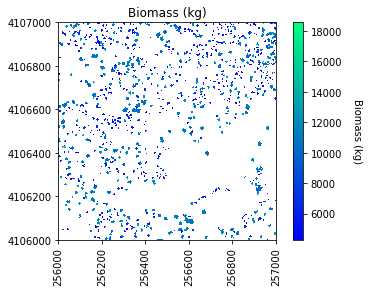

In [30]:
#Get biomass stats for plotting
mean_biomass = np.mean(estimated_biomass)
std_biomass = np.std(estimated_biomass)
min_biomass = np.min(estimated_biomass)
sum_biomass = np.sum(estimated_biomass)

print('Sum of biomass is ',sum_biomass,' kg')

#Plot the biomass!
plt.figure(5)
plot_band_array(biomass_map,chm_array_metadata['extent'],
                'Biomass (kg)','Biomass (kg)',
                'winter',
                [min_biomass+std_biomass, mean_biomass+std_biomass*3])

plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'Biomass.png',
            dpi=300,orientation='landscape',
            bbox_inches='tight',
            pad_inches=0.1)

array2raster('biomass.tif',
             (chm_array_metadata['ext_dict']['xMin'],chm_array_metadata['ext_dict']['yMax']),
             1,-1,np.array(biomass_map,dtype=float),32611)
